In [66]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from numpy.linalg import svd
import scipy
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import sys
from joblib import Parallel, delayed
import tempfile
import os
from joblib import load, dump
import gc
from nltk.corpus import stopwords 
import time
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import nltk

from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, fbeta_score

import warnings
warnings.filterwarnings("ignore")

n_classes = 90
labels = reuters.categories()

In [2]:
vocabulary_path = '/home/ubuntu/Reuters/vocabulary_8000.txt'

In [3]:
def load_word_vectors(vocabulary_path):
    with open(vocabulary_path) as f:
        vocabulary = [x.strip() for x in f]
    return vocabulary

In [4]:
def load_data(config={}, max_features=None, vocabulary=None):
    """
    Load the Reuters dataset.
    Returns
    -------
    data : dict
        with keys 'x_train', 'x_test', 'y_train', 'y_test', 'labels'
    """
    stop_words = stopwords.words("english")
    if max_features is not None:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                     max_features=max_features)
    elif vocabulary is not None:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                     vocabulary=vocabulary)
    else:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b')
    mlb = MultiLabelBinarizer()

    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    xs = {'train': [], 'test': []}
    xs['train'] = vectorizer.fit_transform(docs['train']).toarray()
    xs['test'] = vectorizer.transform(docs['test']).toarray()
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': xs['train'], 'y_train': ys['train'],
            'x_test': xs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data, vectorizer


def load_data_simple():
    mlb = MultiLabelBinarizer()
    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': docs['train'], 'y_train': ys['train'],
            'x_test': docs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data

In [5]:
data = load_data_simple()

In [6]:
print(len(data['x_train']), data['y_train'].shape, len(data['x_test']), data['y_test'].shape)

7769 (7769, 90) 3019 (3019, 90)


In [7]:
def filter_data(data, documents_number_threshold=10):
    indices = np.argwhere(data['y_train'].sum(0) >= documents_number_threshold).ravel()
    documents_numbers = data['y_train'][:, indices].sum(1)
    
    bad_documents = np.argwhere(documents_numbers == 0).ravel()
    good_documents = np.array(sorted(set(range(data['y_train'].shape[0])) - set(bad_documents)))

    documents_numbers_test = data['y_test'][:, indices].sum(1)
    bad_documents_test = np.argwhere(documents_numbers_test == 0).ravel()
    good_documents_test = np.array(sorted(set(range(data['y_test'].shape[0])) - set(bad_documents_test)))

    data_new = {}
    data_new['x_train'] = [data['x_train'][doc_index] for doc_index in good_documents]
    data_new['y_train'] = data['y_train'][good_documents][:, indices]

    data_new['x_test'] = [data['x_test'][doc_index] for doc_index in good_documents_test]
    data_new['y_test'] = data['y_test'][good_documents_test][:, indices]
    return data_new

In [8]:
data_new = filter_data(data, documents_number_threshold=10)

In [9]:
print(len(data_new['x_train']), data_new['y_train'].shape, len(data_new['x_test']), data_new['y_test'].shape)

7741 (7741, 60) 2998 (2998, 60)


In [10]:
# documents number distribution:
pd.value_counts(data_new['y_train'].sum(1))

1     6570
2      865
3      178
4       61
5       35
6       18
7        6
9        4
8        2
10       1
12       1
dtype: int64

In [11]:
stop_words = stopwords.words("english")
vocabulary = load_word_vectors(vocabulary_path)
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b',
                             vocabulary=vocabulary)

vectors = vectorizer.fit_transform(data_new['x_train'])
vectors_test = vectorizer.transform(data_new['x_test'])

labels_train = data_new['y_train']
labels_test = data_new['y_test']


print ('Train:',vectors.shape)
print ('Test:',vectors_test.shape)

Train: (7741, 7169)
Test: (2998, 7169)


In [12]:
def tr_svd(X, n_comp):
    U, S, Vh = scipy.sparse.linalg.svds(X, n_comp)
    S = np.diag(S[::-1])
    U = U[:, ::-1]
    Vh = Vh[::-1,:]
    return U, S, Vh

In [58]:
def fit_predict_class_c_local(X_train, y_train, X_test, class_c, n_comp,real_clf):
    y_train_transformed = np.zeros(y_train.shape[0])
    y_train_transformed = y_train[:,class_c]
    space_indices = np.argwhere(y_train[:,class_c] == 1).reshape(-1,)
    non_space_indices = np.argwhere(y_train[:,class_c] == 0).reshape(-1,)
    n = len(space_indices)
    X_1 = X_train[space_indices]
    X_2 = X_train[non_space_indices]
    y_1 = y_train_transformed[space_indices]
    y_2 = y_train_transformed[non_space_indices]
    if (n_comp<min(X_1.shape)):
        u,s,vh = tr_svd(X_1, n_comp)
    else:
        u,s,vh = tr_svd(X_1, min(X_1.shape)-1)
    X_1_transformed = u @ s
    X_2_transformed = X_2 @ vh.T
    X = np.vstack((X_1_transformed, X_2_transformed))
    y = np.hstack((y_1, y_2))        
    X_test_transformed = X_test @ vh.T
    real_clf.fit(X, y)
    decisions = real_clf.predict(X_test_transformed)
    return decisions

def fit_predict_local(X_train, y_train,X_test,n_comp,real_clf):
    n_classes = y_train.shape[1]
    decisions = []
    
    for i in range(n_classes):
        decisions.append(fit_predict_class_c_local(X_train, y_train,X_test,class_c = i,
                                            n_comp=n_comp,real_clf=real_clf))
    
    decisions = np.vstack(decisions)
    pred = decisions.T
    return pred

In [59]:
def res_append_C_local(X_train, y_train,X_test, y_test,component_list,c):
    results = {}
    for n_comp in component_list:
        real_clf = LinearSVC(C = c)
        t0 = time.time()
        pred = fit_predict_local(X_train, y_train,X_test,n_comp,real_clf)
        print (c, ' ' , n_comp, '---->F1 score=',metrics.f1_score(y_test, pred, average='weighted'), \
                   'time passed: ', time.time() - t0,'\n')
        results[n_comp] = pred
    return results

In [106]:
x_train, x_validate, y_train, y_validate = train_test_split(vectors, labels_train, 
                                                            test_size = 0.25, random_state =42)
initial_clf = LinearSVC(C=0.1, random_state = 42)
real_clf = LinearSVC(C=1, random_state=42)
n_comp = 100
components_list = [10,50, 100,300,500]
c_params = [0.01, 0.1, 1, 10, 100, 120, 150]

In [107]:
results_c_local = Parallel(n_jobs=4)(delayed(res_append_C_local)(x_train, y_train,x_validate, y_validate,
                                      components_list,c)for c in c_params)

1   10 ---->F1 score= 0.745788876817 time passed:  2.8865463733673096 

0.01   10 ---->F1 score= 0.279192908283 time passed:  3.492760181427002 

0.1   10 ---->F1 score= 0.591332306492 time passed:  3.7318637371063232 

10   10 ---->F1 score= 0.779733755839 time passed:  5.78908634185791 

0.1   50 ---->F1 score= 0.645555606731 time passed:  5.774292707443237 

1   50 ---->F1 score= 0.795510466784 time passed:  6.655402183532715 

0.01   50 ---->F1 score= 0.300562285548 time passed:  6.2601637840271 

10   50 ---->F1 score= 0.824206095201 time passed:  9.239688396453857 

0.1   100 ---->F1 score= 0.666170856842 time passed:  9.38809061050415 

1   100 ---->F1 score= 0.814553227264 time passed:  9.791173219680786 

0.01   100 ---->F1 score= 0.304673431098 time passed:  11.418238162994385 

10   100 ---->F1 score= 0.839251904719 time passed:  13.283432006835938 

0.1   300 ---->F1 score= 0.682515073839 time passed:  19.21051263809204 

1   300 ---->F1 score= 0.829242157003 time passed:  

Process ForkPoolWorker-41:
Traceback (most recent call last):


KeyboardInterrupt: 

In [73]:
RES_C_local = []
for n_comp in components_list:
    l =[]
    for n,c in enumerate(c_params):
        pred = results_c_local[n][n_comp]
        res = metrics.f1_score(y_validate, pred, average='weighted')
        l.append(res)
    RES_C_local.append(l)      

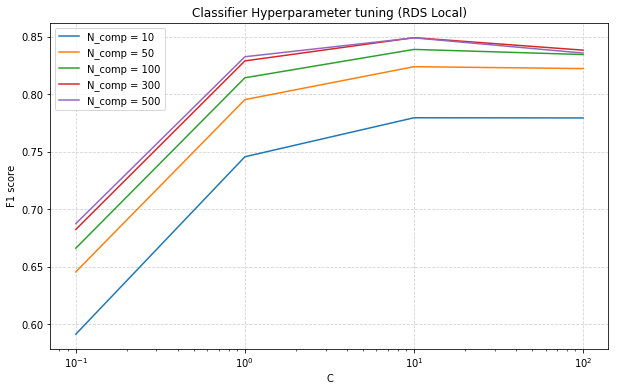

In [105]:
plt.figure(figsize=(10,6))
for n,n_comp in enumerate(components_list):
    plt.semilogx(c_params[1:-2], RES_C_local[n][1:-2],label ='N_comp = {}'.format(n_comp))
        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Classifier Hyperparameter tuning (RDS Local)')
plt.legend()
plt.xlabel('C')
plt.ylabel('F1 score')
plt.savefig("Reuters_Local_grid_search_C_RDS.eps", bbox_inches='tight')
plt.show()

In [77]:
print (vectors.shape)
print (labels_train.shape)
print (vectors_test.shape)

(7741, 7169)
(7741, 60)
(2998, 7169)


In [91]:
components_list_final = [3, 8, 13, 20, 50, 100, 200, 300, 500, 700, 1000]
c = 10
real_clf = LinearSVC(C = c, random_state = 42)

In [94]:
def Compute_Local_RDS_full(n_comp):
    t0 = time.time()
    pred = fit_predict_local(vectors, labels_train, vectors_test,n_comp,real_clf)
    print (n_comp,'---->F1 score=',metrics.f1_score(labels_test, pred, average='weighted'), 'time passed: ', time.time() - t0,'\n')
    return pred

In [95]:
results_RDS_full = Parallel(n_jobs=4)(delayed(Compute_Local_RDS_full)(n_comp)for n_comp in components_list_final)

3 ---->F1 score= 0.701358834327 time passed:  7.580176115036011 

8 ---->F1 score= 0.755571357256 time passed:  10.954994678497314 

13 ---->F1 score= 0.777255523075 time passed:  12.218893051147461 

20 ---->F1 score= 0.798921980638 time passed:  15.74228286743164 

50 ---->F1 score= 0.813220756558 time passed:  24.73194146156311 

100 ---->F1 score= 0.830016574754 time passed:  35.104366302490234 

200 ---->F1 score= 0.833993587798 time passed:  51.592726707458496 

300 ---->F1 score= 0.835369044005 time passed:  64.61278510093689 

500 ---->F1 score= 0.83344330929 time passed:  116.56353855133057 

700 ---->F1 score= 0.83466703294 time passed:  153.5486786365509 

1000 ---->F1 score= 0.835071186992 time passed:  177.85535168647766 



In [ ]:
results_RDS_full[0].shape

In [97]:
RESULTS_FINAL_RDS =[]
f1_scores =[]
precisions = []
recalls =[]
accuracies = []
for n in range(len(components_list_final)):
    pred = results_RDS_full[n]
    f1_scores.append(metrics.f1_score(labels_test, pred, average='weighted'))
    precisions.append(metrics.precision_score(labels_test, pred, average='weighted'))
    recalls.append(metrics.recall_score(labels_test, pred, average='weighted'))
    accuracies.append(metrics.accuracy_score(labels_test, pred))
RESULTS_FINAL_RDS.append(f1_scores)
RESULTS_FINAL_RDS.append(precisions)
RESULTS_FINAL_RDS.append(recalls)
RESULTS_FINAL_RDS.append(accuracies)    

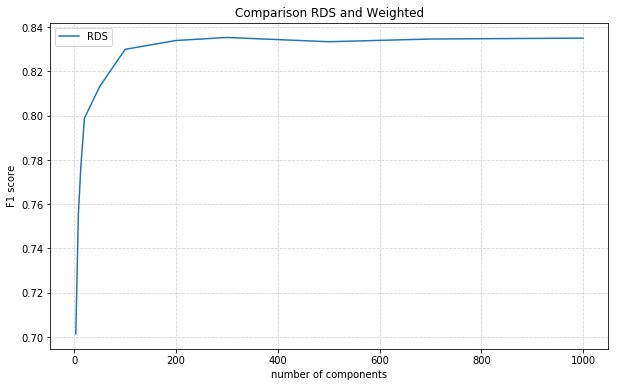

In [99]:
# F1 score
plt.figure(figsize=(10,6))
plt.plot(components_list_final, RESULTS_FINAL_RDS[0],label ='RDS')
#plt.plot(components_list_final, RESULTS_FINAL_WEIGHTED[0],label ='Weighted')        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Comparison RDS and Weighted')
plt.legend()
plt.xlabel('number of components')
plt.ylabel('F1 score')
plt.show()

In [98]:
file_RDS = "Reuters_saved_RDS.npy"
file_scores_RDS = "Reuters_saved_scores_RDS.npy"
np.save(file_RDS, np.array(results_RDS_full))
np.save(file_scores_RDS, np.array(RESULTS_FINAL_RDS))